# Electricity Forecasting - FB Prophet

用 Prophet 來預測被轉容量
https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from prophet import Prophet
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

/opt/anaconda3/envs/python3_8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 參數設定

In [2]:
n_tests = 15 # numbers of days reserved for testing
n_predictions = 18 # 後面幾天是未來時間，要先刪除
start_offset_first = 0
start_offset_second = 0
start_offset_final = 365
# dependencies = ['op_reserve_ratio']
# dependencies = ['peak_supply']
dependencies = ['peak_supply', 'op_reserve_ratio']
first_forecast = 'peak_supply'
second_forecast = 'op_reserve_ratio'
regressors_first = ['is_holiday', 'month', 'year', 'day']
if first_forecast in dependencies:
    regressors_second = [first_forecast, 'is_holiday', 'month', 'year', 'day']
else:
    regressors_second = ['is_holiday', 'month', 'year', 'day']
regressors_op_reserve = dependencies + ['is_holiday', 'day_of_week', 'month']
print(regressors_op_reserve)

['peak_supply', 'op_reserve_ratio', 'is_holiday', 'day_of_week', 'month']


## Data Collation / Wrangling

In [3]:
'''
load data
'''
raw_data = []
raw_data = pd.DataFrame(raw_data)

holiday_data = []
holiday_data = pd.DataFrame(holiday_data)

file = 'Data/台灣電力公司_過去電力供需資訊2017.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(MW)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'op_reserve_ratio']
for idx, date in enumerate(raw_data_new['date']):
    raw_data_new['op_reserve'][idx] /= 10
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data = pd.concat([raw_data, raw_data_new], ignore_index=True)

file = 'Data/台灣電力公司_過去電力供需資訊2018.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(MW)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'op_reserve_ratio']
for idx, date in enumerate(raw_data_new['date']):
    raw_data_new['op_reserve'][idx] /= 10
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data = pd.concat([raw_data, raw_data_new], ignore_index=True)

file = 'Data/近三年每日尖峰備轉容量率2019-2021.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(萬瓩)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'op_reserve_ratio']
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data = pd.concat([raw_data, raw_data_new], ignore_index=True)

file =  'Data/台灣電力公司_本年度每日尖峰備轉容量率2022.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,[True,True,True]]
raw_data_new.columns = ['date', 'op_reserve', 'op_reserve_ratio']
raw_data_new['date'] = pd.to_datetime(raw_data_new['date'])
raw_data = pd.concat([raw_data,raw_data_new], ignore_index=True)

forecast_range = pd.date_range(start=raw_data['date'][len(raw_data['date'])-1] + pd.DateOffset(1), end='2022-04-13')
raw_data_new = pd.DataFrame({'date' : forecast_range})
raw_data = pd.concat([raw_data,raw_data_new], ignore_index=True)

raw_data['year']= pd.DatetimeIndex(raw_data['date']).year
raw_data['month']= pd.DatetimeIndex(raw_data['date']).month
raw_data['day']= pd.DatetimeIndex(raw_data['date']).day
raw_data['day_of_week'] = raw_data['date'].dt.dayofweek

# print(raw_data)

for file in ['Data/106年政府機關辦公日曆表.csv',
             'Data/107政府機關辦公日曆表(數字版).csv',
             'Data/108年中華民國政府行政機關辦公日曆表.csv',
             'Data/109年中華民國政府行政機關辦公日曆表.csv',
             'Data/110中華民國政府行政機關辦公日曆表.csv',
             'Data/111年中華民國政府行政機關辦公日曆表.csv']:
    raw_data_new = pd.read_csv(file)
    raw_data_new = pd.DataFrame(raw_data_new)
    raw_data_new = raw_data_new.loc[:,[True, False, True, False]]
    raw_data_new.columns=['date','is_holiday']
    for idx, date in enumerate(raw_data_new['date']):
        date = str(raw_data_new['date'][idx])
        raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
    raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
    raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
    raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
    raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
    raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek
    holiday_data = pd.concat([holiday_data, raw_data_new])

raw_data = holiday_data.merge(raw_data)

'''
Trim outliers & convert unit
'''
# FIXME: use difference instead?
op_reserve_mean = round(float(raw_data['op_reserve'].mean()), 1)
raw_data['peak_supply'] = raw_data['op_reserve_ratio'].values
for i, op_reserve in enumerate(raw_data['op_reserve']):
    raw_data['op_reserve'][i] = raw_data['op_reserve'][i] * 10
    raw_data['peak_supply'][i] = raw_data['op_reserve'][i] * 100 / raw_data['op_reserve_ratio'][i]
    

raw_data.to_csv('training_data.csv');

'''
split training set and testing set
'''
train = raw_data[start_offset_first:-n_tests-n_predictions]
test = raw_data[-n_tests-n_predictions:-n_predictions]

print(train)
print(test)

           date  is_holiday  year  month  day  day_of_week  op_reserve  \
0    2017-01-02           2  2017      1    2            0      1550.0   
1    2017-01-03           0  2017      1    3            1      1020.0   
2    2017-01-04           0  2017      1    4            2      1270.0   
3    2017-01-05           0  2017      1    5            3      1720.0   
4    2017-01-06           0  2017      1    6            4      1150.0   
...         ...         ...   ...    ...  ...          ...         ...   
1890 2022-03-07           0  2022      3    7            0      2527.0   
1891 2022-03-08           0  2022      3    8            1      3290.0   
1892 2022-03-09           0  2022      3    9            2      2550.0   
1893 2022-03-10           0  2022      3   10            3      3088.0   
1894 2022-03-11           0  2022      3   11            4      3148.0   

      op_reserve_ratio   peak_supply  
0                 6.34  24447.949527  
1                 3.63  28099.173

<AxesSubplot:xlabel='date'>

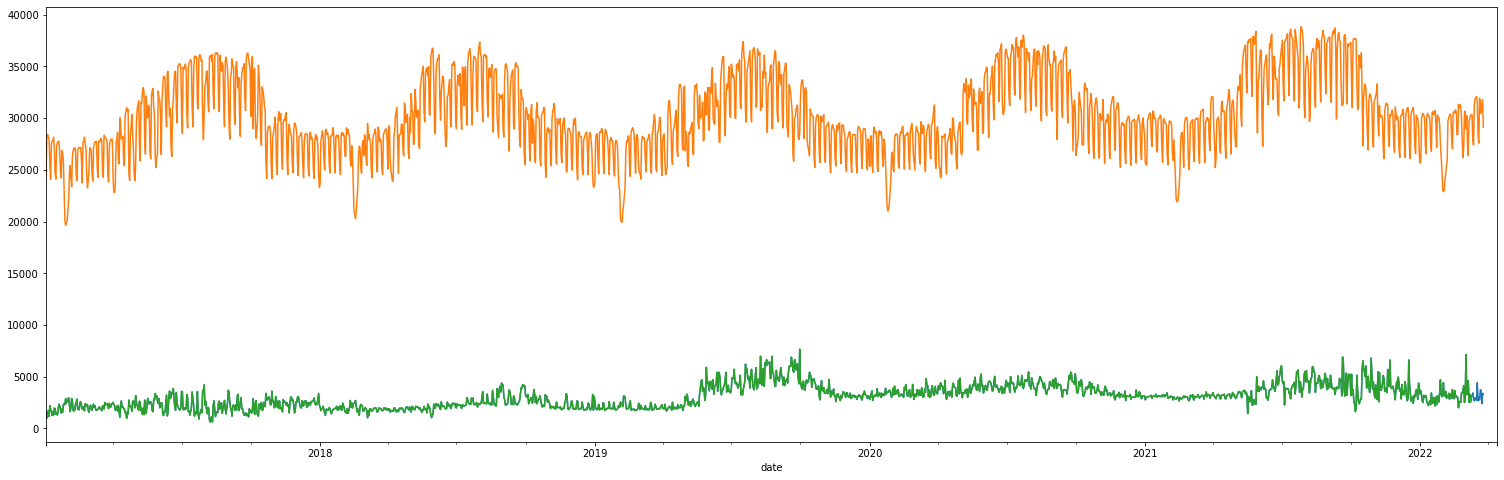

In [4]:
raw_data_tmp = raw_data[:]
raw_data_tmp.set_index('date',inplace=True)
raw_data_tmp['op_reserve'].plot(label='first_data', figsize=(26,8))
raw_data_tmp['peak_supply'].plot(label='first_data', figsize=(26,8))

train_tmp = train[:]
train_tmp.set_index('date',inplace=True)
train_tmp['op_reserve'].plot(label='first_data', figsize=(26,8))

<AxesSubplot:xlabel='date'>

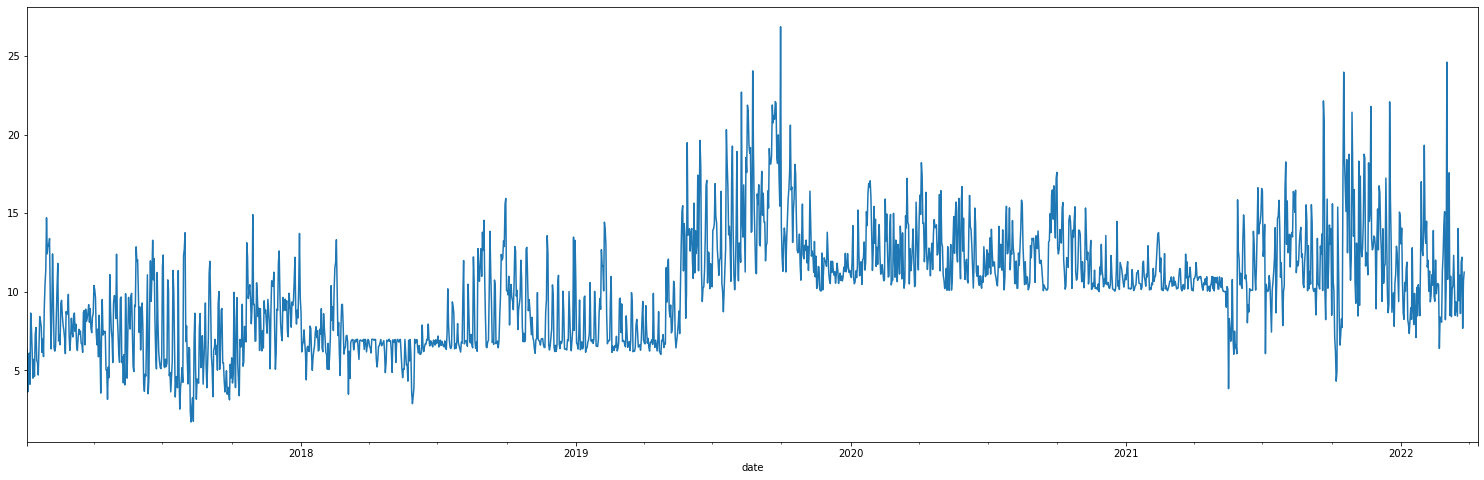

In [5]:
raw_data_tmp['op_reserve_ratio'].plot(label='first_data', figsize=(26,8))

## FB Prophet

### 先預測尖峰供電

In [6]:
prophet_data = train[:]
prophet_data.rename(columns={first_forecast: 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [7]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=True, 
                weekly_seasonality=True,
                changepoint_range=0.55,
                seasonality_mode='additive')
for regressor in regressors_first:
    model.add_regressor(regressor)
model.fit(prophet_data)

Initial log joint probability = -16.0135


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5579.72   0.000103037       164.168      0.8062      0.8062      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5581.85   0.000739342       145.298           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       5582.31   3.65684e-05       155.797   2.311e-07       0.001      349  LS failed, Hessian reset 
     299       5582.54   0.000169864       111.701           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5582.85   7.75081e-05       90.0375           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       5582.88   1.60736e-05       108.966   1.846e-07       0.001      5

In [8]:
prophet_data.tail()

,index,ds,is_holiday,year,month,day,day_of_week,op_reserve,op_reserve_ratio,y
1890,1890,2022-03-07,0,2022,3,7,0,2527.0,8.50,29729.411765
1891,1891,2022-03-08,0,2022,3,8,1,3290.0,10.99,29936.305732
1892,1892,2022-03-09,0,2022,3,9,2,2550.0,8.42,30285.035629
1893,1893,2022-03-10,0,2022,3,10,3,3088.0,10.18,30333.988212
1894,1894,2022-03-11,0,2022,3,11,4,3148.0,10.37,30356.798457


In [9]:
future = test.rename(columns={'date': 'ds'})
# future.drop(['op_reserve'], axis = 1, inplace=True)
future.head()

,ds,is_holiday,year,month,day,day_of_week,op_reserve,op_reserve_ratio,peak_supply
1895,2022-03-12,2,2022,3,12,5,3438.0,12.32,27905.844156
1896,2022-03-13,2,2022,3,13,6,2839.0,10.36,27403.474903
1897,2022-03-14,0,2022,3,14,0,2659.0,8.50,31282.352941
1898,2022-03-15,0,2022,3,15,1,2986.0,9.37,31867.662753
1899,2022-03-16,0,2022,3,16,2,2859.0,8.94,31979.865772


In [10]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-12,31982.885788,26123.719791,29264.040741,31982.885788,31982.885788,-4240.816650,-4240.816650,-4240.816650,5.575455,...,702.464256,702.464256,702.464256,-2688.333512,-2688.333512,-2688.333512,0.0,0.0,0.0,27742.069139
1,2022-03-13,31985.561576,25337.068471,28435.065236,31985.561576,31985.561576,-5156.944011,-5156.944011,-5156.944011,4.054366,...,702.464256,702.464256,702.464256,-2686.746346,-2686.746346,-2686.746346,0.0,0.0,0.0,26828.617565
2,2022-03-14,31988.237363,29772.802143,32944.547265,31988.237363,31988.237363,-706.325545,-706.325545,-706.325545,2.533276,...,702.464256,702.464256,702.464256,-2683.410595,-2683.410595,-2683.410595,0.0,0.0,0.0,31281.911818
3,2022-03-15,31990.913151,30075.175723,33210.849663,31990.913151,31990.913151,-436.361430,-436.361430,-436.361430,1.012187,...,702.464256,702.464256,702.464256,-2677.643639,-2677.643639,-2677.643639,0.0,0.0,0.0,31554.551721
4,2022-03-16,31993.588938,30068.688459,33133.933800,31993.588938,31993.588938,-413.419641,-413.419641,-413.419641,-0.508903,...,702.464256,702.464256,702.464256,-2668.855373,-2668.855373,-2668.855373,0.0,0.0,0.0,31580.169297


In [11]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:][first_forecast].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
model.plot(forecast)

### 將預測結果代入

In [ ]:
if first_forecast in dependencies:
    test[first_forecast] = forecast_simplified['forecast'].values

### 預測第二個值

In [ ]:
'''
split training set and testing set
'''
train = raw_data[start_offset_second:-n_tests]
test = raw_data[-n_tests:]

In [ ]:
prophet_data = train[:]
prophet_data.rename(columns={second_forecast: 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [ ]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=True, 
                weekly_seasonality=False, 
                seasonality_mode='additive',
                changepoint_range=0.9,
                changepoint_prior_scale=100,
                seasonality_prior_scale=100)
for regressor in regressors_second:
    model.add_regressor(regressor)
model.fit(prophet_data)

In [ ]:
future = test.rename(columns={'date': 'ds'})
# future.drop(['op_reserve'], axis = 1, inplace=True)
future.head()

In [ ]:
forecast = model.predict(future)
forecast.head()

In [ ]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:][second_forecast].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')

In [ ]:
if second_forecast in dependencies:
    test[second_forecast] = forecast_simplified['forecast'].values

### 接著預測備轉容量

In [ ]:
'''
split training set and testing set
'''
train = raw_data[start_offset_final:-n_tests]
test = raw_data[-n_tests:]

In [ ]:
prophet_data = train[:]
prophet_data.rename(columns={'op_reserve': 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [ ]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=False, 
                weekly_seasonality=False, 
                seasonality_mode='additive',
                changepoint_range=0.95,
                changepoint_prior_scale=100,
                seasonality_prior_scale=100
                )
for regressor in regressors_op_reserve:
    model.add_regressor(regressor)
model.fit(prophet_data)

In [ ]:
future = test.rename(columns={'date': 'ds'})
future.head()

In [ ]:
forecast = model.predict(future)
forecast.head()

In [ ]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:]['op_reserve'].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')
forecast_simplified.head()

In [ ]:
model.plot(forecast)

### 或是直接將兩者乘起來

In [ ]:
forecast_final= test[-n_tests:][['date', 'op_reserve_ratio', 'peak_supply', 'op_reserve']]
forecast_final.reset_index(drop=True, inplace=True)
forecast_simplified.head()
for i, item in enumerate(forecast_final['op_reserve']):
    forecast_final['op_reserve'][i] = forecast_final['peak_supply'][i] * forecast_final['op_reserve_ratio'][i] / 100
forecast_final['actual'] = raw_data[-n_tests:]['op_reserve'].values
forecast_final.rename(columns={'op_reserve': 'forecast'}, inplace=True)
forecast_final = forecast_final.loc[:,['forecast', 'actual']]
'''
印出結果
'''
rmse = mean_squared_error(forecast_final['forecast'], forecast_final['actual'], squared=False)
print('RMSE =', rmse)
forecast_final.plot(label='test_data')

In [ ]:
forecast_final.head()

## Master Cell: Test Different Parameters
`start_offset_first`
`start_offset_second`
`multistep`